In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

In [2]:
data = pd.read_csv("營養份數表_all new.csv")
# 顯示dataset的形狀，共21613比資料，每一比資料有21種不同資訊。
data.shape
# 將顯示列數設定為25，不然會有部份資料無法顯示
pd.options.display.max_columns = 25
# head 會顯示前五行的數據
data.drop(['file'], axis="columns", inplace=True)
data.head()

,rice_num,meat_num,veg_num,oil_num,heat,vegtable,rice,meat,fried meat,meat_total
0,4.0,3.5,1.5,3.0,712.5,0.393413,0.017153,0.358917,0.0,0.538376
1,4.0,3.0,1.5,2.0,629.0,0.267304,0.018920,0.324080,0.0,0.486120
2,5.5,4.5,0.6,3.5,874.4,0.047228,0.122384,0.340319,0.0,0.510478
3,4.5,3.5,1.7,3.5,759.8,0.148725,0.031444,0.318160,0.0,0.477240
4,2.0,2.0,0.6,1.5,429.5,0.045313,0.053156,0.093271,0.0,0.139907


### meat ###

In [3]:
data_num = data.shape[0]
# 取得一筆與data數量相同的亂數索引，主要目的是用於打散資料
indexes = np.random.permutation(data_num)
# 並將亂數索引值分為Train、validation和test分為，這裡的劃分比例為6:2:2
train_indexes = indexes[:int(data_num *0.8)]
val_indexes = indexes[int(data_num *0.8):int(data_num *0.9)]
test_indexes = indexes[int(data_num *0.9):]
# 透過索引值從data取出訓練資料、驗證資料和測試資料
train_data = data.loc[train_indexes]
val_data = data.loc[val_indexes]
test_data = data.loc[test_indexes]

In [13]:
x_train = np.array(train_data.drop(['rice_num','meat_num','veg_num','oil_num','heat','meat_total'], axis=1))
y_train = np.array(train_data.drop(['oil_num','heat','vegtable','rice','meat','fried meat','meat_total'], axis=1))
x_val = np.array(val_data.drop(['rice_num','meat_num','veg_num','oil_num','heat','meat_total'], axis=1))
y_val = np.array(val_data.drop(['oil_num','heat','vegtable','rice','meat','fried meat','meat_total'], axis=1))
print(x_train)
x_train.shape

[[0.12283462 0.07993665 0.01128612 0.        ]
 [0.03352488 0.12194381 0.21677454 0.24224633]
 [0.03700409 0.20135968 0.13335829 0.        ]
 ...
 [0.03376871 0.01504762 0.10540952 0.        ]
 [0.10798207 0.13826454 0.01479535 0.1159864 ]
 [0.20761911 0.0163567  0.24790286 0.        ]]


(287, 4)

In [5]:
mean_train = y_train.mean()
mean_test= y_val.mean()
std_train = y_train.std()
std_test=y_val.std()
y_train = (y_train - mean_train) / std_train
y_val = (y_val - mean_test) / std_test

In [6]:
input_data=tf.keras.Input(shape=(4,))
x=Dense(32, activation='relu')(input_data)
x=layers.Dropout(0.3)(x)
x=Dense(16, activation='relu')(x)
x=layers.Dropout(0.3)(x)
output=Dense(3)(x)
model=Model(inputs=input_data, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 32)                160       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 739
Trainable params: 739
Non-trainable params:

In [7]:
model.compile(keras.optimizers.Adam(),
             loss=keras.losses.MeanSquaredError(),
             metrics=[keras.metrics.MeanAbsoluteError()])

In [8]:
# 設定回調函數：
# TensorBoard回調函數會幫忙紀錄訓練資訊，並存成TensorBoard的紀錄檔
model_dir = 'lab2-logs/models/'
log_dir = os.path.join('lab2-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# ModelCheckpoint回調函數幫忙儲存網路模型，可以設定只儲存最好的模型，「monitor」表示被監測的數據，「mode」min則代表監測數據越小越好。
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.h5',monitor='val_mean_absolute_error',save_best_only=True,mode='min')

In [9]:
# 訓練網路模型：
history = model.fit(x_train, y_train,  # 傳入訓練數據
               batch_size=64,  # 批次大小設為64
               epochs=110,  # 整個dataset訓練300遍
               validation_data=(x_val, y_val),  # 驗證數據
               callbacks=[model_cbk, model_mckp]) 
 # Tensorboard回調函數紀錄訓練過程，ModelCheckpoint回調函數儲存最好的模型

Epoch 1/110
5/5 [==============================] - 1s 39ms/step - loss: 0.9790 - mean_absolute_error: 0.7747 - val_loss: 0.9646 - val_mean_absolute_error: 0.7982
Epoch 2/110
5/5 [==============================] - 0s 13ms/step - loss: 0.9564 - mean_absolute_error: 0.7632 - val_loss: 0.9392 - val_mean_absolute_error: 0.7865
Epoch 3/110
5/5 [==============================] - 0s 13ms/step - loss: 0.9290 - mean_absolute_error: 0.7499 - val_loss: 0.9104 - val_mean_absolute_error: 0.7727
Epoch 4/110
5/5 [==============================] - 0s 13ms/step - loss: 0.8955 - mean_absolute_error: 0.7339 - val_loss: 0.8777 - val_mean_absolute_error: 0.7565
Epoch 5/110
5/5 [==============================] - 0s 13ms/step - loss: 0.8683 - mean_absolute_error: 0.7204 - val_loss: 0.8401 - val_mean_absolute_error: 0.7374
Epoch 6/110
5/5 [==============================] - 0s 14ms/step - loss: 0.8332 - mean_absolute_error: 0.7034 - val_loss: 0.7996 - val_mean_absolute_error: 0.7157
Epoch 7/110
5/5 [===========

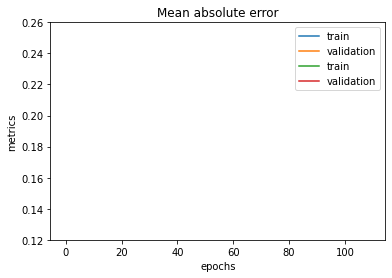

In [10]:
history.history.keys()  # 查看history儲存的資訊有哪些
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0.02, 0.2)
plt.title('Mean square error')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='validation')
plt.ylim(0.12, 0.26)
plt.title('Mean absolute error')
plt.ylabel('metrics')
plt.xlabel('epochs')
plt.legend(loc='upper right')

In [11]:
#rice_num  meat_num  veg_num  oil_num
pred=model.predict(x_val)
pred=pred*std_test+mean_test
print(pred)
percentage_error = np.mean(np.abs(y_val*std_test+mean_test - pred)) / np.mean(y_val*std_test+mean_test) * 100
# 顯示誤差百分比
print("Model_1 Percentage Error: {:.2f}%".format(percentage_error))

2/2 [==============================] - 0s 2ms/step
[[4.346553  2.2002296 1.4626055]
 [4.2843738 2.3294067 1.432463 ]
 [4.458857  2.8397949 1.1294979]
 [4.371771  2.50876   1.3478829]
 [4.3538456 2.2667673 1.3011502]
 [4.2962203 2.3665044 1.3876215]
 [4.285296  2.2852173 1.3887808]
 [4.3015833 2.4675252 1.407012 ]
 [4.3132577 2.4467733 1.4595267]
 [4.1300673 2.4590847 1.8119051]
 [4.3582745 2.5328736 1.52808  ]
 [4.1987343 2.273568  1.5683177]
 [4.2889657 2.348293  1.432489 ]
 [4.281389  2.2567892 1.3903627]
 [4.3470488 2.453381  1.3475498]
 [4.332882  2.224586  1.3810247]
 [4.5706816 2.8267527 1.5280752]
 [4.2651744 2.347508  1.5385644]
 [4.2115927 2.2714014 1.455075 ]
 [4.2913055 2.2949631 1.3454732]
 [4.1949425 2.2676373 1.5518677]
 [4.342412  2.3601196 1.364095 ]
 [4.4825897 2.259224  1.6107507]
 [4.296979  2.4939733 1.463121 ]
 [4.22568   2.6752286 1.6819282]
 [4.3079457 2.3467553 1.5291009]
 [4.438784  2.5167785 1.4020329]
 [4.766193  2.624439  1.1061296]
 [4.3046308 2.3407428 1.5

In [12]:
print(y_val*std_test+mean_test)

[[3.27 3.76 0.57]
 [5.37 2.8  1.82]
 [3.2  2.9  1.3 ]
 [3.76 2.59 0.97]
 [3.72 1.61 0.76]
 [3.84 3.42 0.94]
 [6.95 1.57 0.72]
 [3.5  2.   2.  ]
 [6.2  3.5  1.8 ]
 [4.   1.5  2.  ]
 [5.   4.   1.8 ]
 [2.83 3.22 0.67]
 [4.57 1.29 0.21]
 [4.   4.5  1.7 ]
 [2.68 2.3  1.05]
 [6.38 2.37 0.92]
 [4.2  3.5  1.25]
 [5.09 1.2  0.98]
 [4.68 2.17 1.25]
 [4.72 2.31 1.26]
 [9.17 2.26 1.23]
 [2.76 0.97 1.29]
 [5.7  3.59 1.4 ]
 [5.32 2.87 1.49]
 [4.   2.   1.3 ]
 [3.9  2.4  1.4 ]
 [5.   2.5  1.  ]
 [4.   1.5  0.7 ]
 [5.3  2.4  1.4 ]
 [5.   2.   1.6 ]
 [4.6  2.   1.7 ]
 [6.5  2.5  1.5 ]
 [3.3  2.5  1.6 ]
 [4.2  0.8  3.  ]
 [4.9  2.7  1.8 ]
 [3.36 0.95 2.45]]
